## Using the ST-DBSCAN Algorithm

In [41]:
from geofeather import to_geofeather, from_geofeather
from matplotlib import pyplot as plt
import feather
import numpy as np
import pandas as pd
import folium

### Functions

In [2]:
## source: https://github.com/gitAtila/ST-DBSCAN ##
import math
from datetime import timedelta
from geopy.distance import great_circle
"""
INPUTS:
    df={o1,o2,...,on} Set of objects
    spatial_threshold = Maximum geographical coordinate (spatial) distance value (Eps1)
    temporal_threshold = Maximum non-spatial distance value (Eps2)
    min_neighbors = Minimun number of points within Eps1 and Eps2 distance
OUTPUT:
    C = {c1,c2,...,ck} Set of clusters
"""
def ST_DBSCAN(df, spatial_threshold, temporal_threshold, min_neighbors):
    cluster_label = 0
    NOISE = -1
    UNMARKED = 777777
    stack = []

    # initialize each point with unmarked
    df['cluster'] = UNMARKED
    
    # for each point in database
    for index, point in df.iterrows():
        if df.loc[index]['cluster'] == UNMARKED:
            neighborhood = retrieve_neighbors(index, df, spatial_threshold, temporal_threshold)
            
            if len(neighborhood) < min_neighbors:
                df.at[index, 'cluster'] = NOISE

            else: # found a core point
                cluster_label = cluster_label + 1
                df.at[index, 'cluster'] = cluster_label# assign a label to core point

                for neig_index in neighborhood: # assign core's label to its neighborhood
                    df.at[neig_index, 'cluster'] = cluster_label
                    stack.append(neig_index) # append neighborhood to stack
                
                while len(stack) > 0: # find new neighbors from core point neighborhood
                    current_point_index = stack.pop()
                    new_neighborhood = retrieve_neighbors(current_point_index, df, spatial_threshold, temporal_threshold)
                    
                    if len(new_neighborhood) >= min_neighbors: # current_point is a new core
                        for neig_index in new_neighborhood:
                            neig_cluster = df.loc[neig_index]['cluster']
                            if (neig_cluster != NOISE) & (neig_cluster == UNMARKED): 
                                # TODO: verify cluster average before add new point
                                df.at[neig_index, 'cluster'] = cluster_label
                                stack.append(neig_index)
    return df


def retrieve_neighbors(index_center, df, spatial_threshold, temporal_threshold):
    neigborhood = []

    center_point = df.loc[index_center]

    # filter by time 
    min_time = center_point['date_time'] - timedelta(minutes = temporal_threshold)
    max_time = center_point['date_time'] + timedelta(minutes = temporal_threshold)
    df = df[(df['date_time'] >= min_time) & (df['date_time'] <= max_time)]

    # filter by distance
    for index, point in df.iterrows():
        if index != index_center:
            distance = great_circle((center_point['latitude'], center_point['longitude']), (point['latitude'], point['longitude'])).meters
            if distance <= spatial_threshold:
                neigborhood.append(index)

    return neigborhood

In [3]:
def dfScatter(df, xcol='longitude', ycol='latitude', catcol='cluster'):
    fig, ax = plt.subplots()
    categories = np.unique(df[catcol])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))  

    df["Color"] = df[catcol].apply(lambda x: colordict[x])
    ax.scatter(df[xcol], df[ycol], c=df.Color)
    return fig

### Data Import

In [4]:
#importing tracks data
track_df = from_geofeather('Data/Monchengladbach_new.feather')
track_df.columns

Index(['level_0', 'index', 'id', 'time', 'geometry', 'GPS Bearing.value',
       'GPS Bearing.unit', 'Intake Temperature.value',
       'Intake Temperature.unit', 'MAF.value', 'MAF.unit',
       'Intake Pressure.value', 'Intake Pressure.unit', 'Engine Load.value',
       'Engine Load.unit', 'GPS Accuracy.value', 'GPS Accuracy.unit',
       'GPS Altitude.value', 'GPS Altitude.unit', 'Rpm.value', 'Rpm.unit',
       'GPS Speed.value', 'GPS Speed.unit', 'GPS VDOP.value', 'GPS VDOP.unit',
       'GPS PDOP.value', 'GPS PDOP.unit', 'Speed.value', 'Speed.unit',
       'GPS HDOP.value', 'GPS HDOP.unit', 'track.id', 'track.length',
       'track.begin', 'track.end', 'sensor.type', 'sensor.engineDisplacement',
       'sensor.model', 'sensor.id', 'sensor.fuelType',
       'sensor.constructionYear', 'sensor.manufacturer',
       'Calculated MAF.value', 'Calculated MAF.unit', 'CO2.value', 'CO2.unit',
       'Consumption.value', 'Consumption.unit', 'Throttle Position.value',
       'Throttle Position

In [5]:
df = track_df.dropna(subset = ['time'])
len(df)

21708

In [6]:
df['latitude'] = df['geometry'].apply(lambda coord: coord.y)
df['longitude'] = df['geometry'].apply(lambda coord: coord.x)
df['date_time'] = pd.to_datetime(df['time']) #convert to datetime object

# df_table must have the columns: 'latitude', 'longitude' and 'date_time'
df_table = df[['latitude', 'longitude', 'date_time']].copy()
df_table.head()

,latitude,longitude,date_time
0,51.203280,6.414546,2018-07-11 06:07:23
1,51.203085,6.415119,2018-07-11 06:07:28
2,51.202986,6.415637,2018-07-11 06:07:33
3,51.202912,6.416147,2018-07-11 06:07:38
4,51.202825,6.416707,2018-07-11 06:07:43


In [26]:
%%time
#setting thresholds
spatial_threshold = 100 # meters
temporal_threshold = 1  # minutes
min_neighbors = 40
#clustering
df_clustering = ST_DBSCAN(df_table, spatial_threshold, temporal_threshold, min_neighbors)
df_clustering.head()

Wall time: 10min 27s


,latitude,longitude,date_time,cluster,Color
0,51.203280,6.414546,2018-07-11 06:07:23,-1,0.0
1,51.203085,6.415119,2018-07-11 06:07:28,-1,0.0
2,51.202986,6.415637,2018-07-11 06:07:33,-1,0.0
3,51.202912,6.416147,2018-07-11 06:07:38,-1,0.0
4,51.202825,6.416707,2018-07-11 06:07:43,-1,0.0


In [31]:
df_clustering.groupby(['cluster']).count()

,latitude,longitude,date_time,Color
cluster,,,,
-1,20763,20763,20763,20763
1,42,42,42,42
2,51,51,51,51
3,42,42,42,42
4,47,47,47,47
5,41,41,41,41
6,47,47,47,47
7,52,52,52,52
8,59,59,59,59


In [32]:
df_clustering = df_clustering[df_clustering['cluster'] != -1]

In [33]:
df_clustering['cluster'].nunique() #number of clusters

19

In [45]:
df_clustering.groupby(['Color']).count()

,index,latitude,longitude,date_time,cluster
Color,,,,,
0.000000,42,42,42,42,42
0.055556,51,51,51,51,51
0.111111,42,42,42,42,42
0.166667,47,47,47,47,47
0.222222,41,41,41,41,41
0.277778,47,47,47,47,47
0.333333,52,52,52,52,52
0.388889,59,59,59,59,59
0.444444,42,42,42,42,42


<ipython-input-3-15a3b93b23ac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Color"] = df[catcol].apply(lambda x: colordict[x])


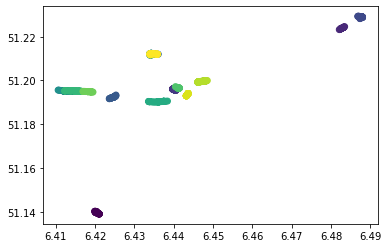

In [34]:
#df_clustering is panda dataframe
fig = dfScatter(df_clustering)

In [50]:
def map(m, data, value = 'cluster', lat = 'latitude', lng = 'longitude', col ='#f09205'):

    lats = data[lat]
    lngs = data[lng]

    avg_lat = sum(lats) / len(lats)
    avg_lngs = sum(lngs) / len(lngs)

    latlngs = []
    

    color = [col]*len(data)
    for lat,lng,c in zip(lats, lngs, color):
        folium.CircleMarker([lat,lng], color = c, radius =3, fill = c).add_to(m)
        latlngs.append([lat,lng])

    m.fit_bounds(latlngs)

In [51]:
m = folium.Map(tiles = 'Stamen Terrain', zoom_start=12)
map(m, df_clustering)
m

In [38]:
#conversion to feather format
df_clustering_copy = df_clustering.reset_index(inplace = True)
df_clustering.to_feather('Data/stdbscan_100_1_40.feather')

In [39]:
#importing and checking data from feather
df_clustering_df = pd.read_feather('Data/stdbscan_cluster.feather')

In [40]:
df_clustering_df.head()

,index,latitude,longitude,date_time,cluster
0,0,51.203280,6.414546,2018-07-11 06:07:23,1
1,1,51.203085,6.415119,2018-07-11 06:07:28,1
2,2,51.202986,6.415637,2018-07-11 06:07:33,1
3,3,51.202912,6.416147,2018-07-11 06:07:38,1
4,4,51.202825,6.416707,2018-07-11 06:07:43,1
